# General Dependencies

In [3]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [4]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [5]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

22:01:11 INFO    1204325400.py:12: WORKING!


# Setup

In [6]:
from time import sleep

from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks")


In [7]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

c:\Users\magod\anaconda3\envs\env_uma\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


22:01:20 INFO    ocr_local.py:131: OCRInterface initialized | lang=en device=cpu


In [8]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(ctrl=ctrl)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

22:01:22 INFO    yolo_local.py:30: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma.pt


# Lookup

## Real Time

22:01:29 DEBUG   29272047.py:105: Screen Detection: Lobby | {'tazuna': True, 'infirmary': True, 'has_lobby_skills': True}


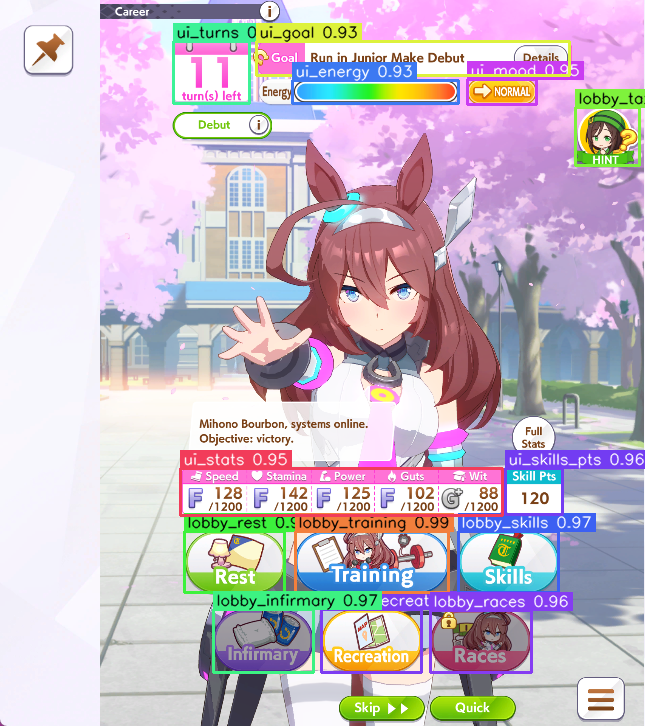

00 | lobby_rest           | conf=0.993 | xyxy=(184.9,531.1,284.9,592.4)
01 | lobby_recreation     | conf=0.987 | xyxy=(321.1,609.7,421.5,672.1)
02 | lobby_training       | conf=0.987 | xyxy=(295.5,531.8,448.7,592.9)
03 | ui_turns             | conf=0.979 | xyxy=(173.2,41.1,249.7,103.7)
04 | lobby_skills         | conf=0.975 | xyxy=(458.9,531.4,558.9,592.7)
05 | lobby_infirmary      | conf=0.968 | xyxy=(213.5,609.9,313.4,672.1)
06 | lobby_races          | conf=0.962 | xyxy=(430.4,610.2,531.5,672.0)
07 | ui_skills_pts        | conf=0.960 | xyxy=(505.7,469.0,562.8,514.7)
08 | lobby_tazuna         | conf=0.956 | xyxy=(575.4,108.0,639.4,165.6)
09 | ui_stats             | conf=0.949 | xyxy=(180.3,468.3,502.4,515.0)
10 | ui_mood              | conf=0.949 | xyxy=(467.3,79.2,536.3,104.4)
11 | ui_goal              | conf=0.934 | xyxy=(256.0,41.5,569.7,75.8)
12 | ui_energy            | conf=0.926 | xyxy=(292.8,80.4,458.7,103.7)


In [9]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=param_conf,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


## Static

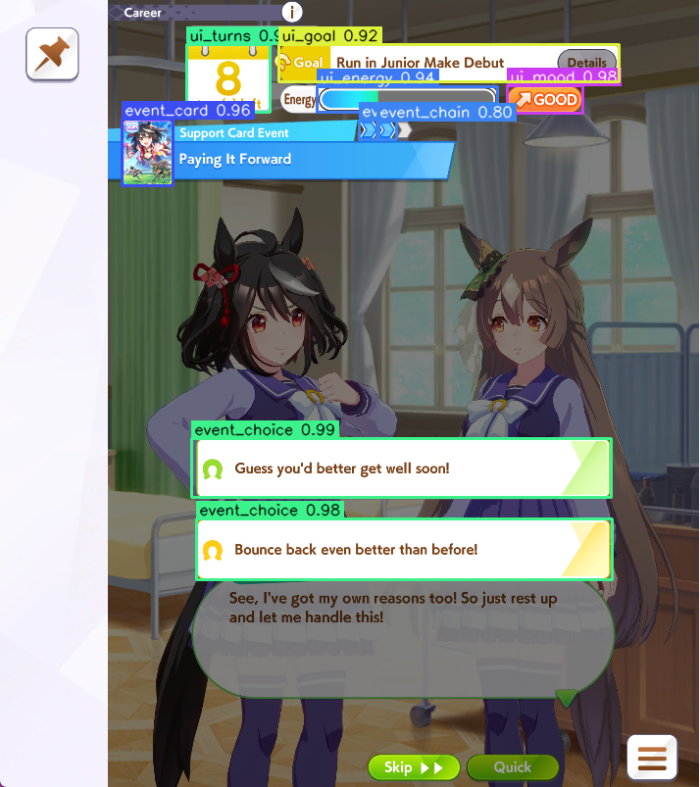

00 | event_choice         | conf=0.994 | xyxy=(195.2,447.5,623.1,507.8)
01 | event_choice         | conf=0.984 | xyxy=(200.1,529.5,624.0,591.7)
02 | ui_mood              | conf=0.978 | xyxy=(517.2,87.4,594.1,115.5)
03 | ui_turns             | conf=0.977 | xyxy=(190.6,45.2,275.9,114.2)
04 | event_card           | conf=0.960 | xyxy=(124.8,121.5,176.2,189.7)
05 | ui_energy            | conf=0.940 | xyxy=(323.5,88.8,507.8,114.4)
06 | ui_goal              | conf=0.922 | xyxy=(284.1,45.0,631.6,83.7)
07 | event_chain          | conf=0.823 | xyxy=(366.3,122.9,386.5,142.4)
08 | event_chain          | conf=0.799 | xyxy=(384.8,123.5,404.0,142.5)


In [ ]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------
from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine


img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl_static = StaticImageController(img)
yolo_engine_static = LocalYOLOEngine(ctrl=ctrl_static)


assert ctrl_static.focus()

# recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine_static.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


In [30]:
# Save segment
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Literal
from PIL import Image

def _clamp_box(x1: int, y1: int, x2: int, y2: int, w: int, h: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    # Ensure x2>x1 and y2>y1 (at least 1px box)
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return x1, y1, x2, y2

def _expand_box(x1: int, y1: int, x2: int, y2: int,
                w: int, h: int,
                pad_px: int = 0,
                pad_pct: float = 0.0) -> Tuple[int, int, int, int]:
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = pad_px + int(bw * pad_pct)
    py = pad_px + int(bh * pad_pct)
    return _clamp_box(x1 - px, y1 - py, x2 + px, y2 + py, w, h)

def crop_by_class(
    pil_img: Image.Image,
    dets: List[Dict],
    class_name: str,
    out_dir: str,
    *,
    conf_min: float = 0.0,
    mode: Literal["best","all","index"] = "best",
    index: Optional[int] = None,          # used when mode="index" (0-based within filtered list)
    pad_px: int = 0,
    pad_pct: float = 0.0,                 # e.g. 0.05 → +5% of box size on all sides
    prefix: Optional[str] = None,
    fmt: str = "png",                     # "png" or "jpg"
) -> List[Tuple[str, Image.Image, Dict]]:
    """
    Find detections with name == class_name and save crops to `out_dir`.

    Returns a list of (saved_path, crop_image, det_dict) in the order saved.
    If nothing matches, returns [].

    - mode="best": only highest-confidence match
      mode="index": only the Nth match after sorting by confidence (index required)
      mode="all": save all matches (sorted by confidence desc)
    """
    # Filter & sort candidates
    cands = [d for d in (dets or []) if str(d.get("name","")) == class_name and float(d.get("conf",0.0)) >= conf_min]
    cands.sort(key=lambda d: float(d.get("conf", 0.0)), reverse=True)

    if not cands:
        return []

    if mode == "best":
        chosen = [cands[0]]
    elif mode == "index":
        if index is None or index < 0 or index >= len(cands):
            return []
        chosen = [cands[index]]
    else:  # "all"
        chosen = cands

    # Prepare output
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    w, h = pil_img.size

    results: List[Tuple[str, Image.Image, Dict]] = []
    for rank, d in enumerate(chosen):
        x1, y1, x2, y2 = d.get("xyxy", (0,0,0,0))
        # Round to ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # Optional padding and clamp
        x1, y1, x2, y2 = _expand_box(x1, y1, x2, y2, w, h, pad_px=pad_px, pad_pct=pad_pct)

        crop = pil_img.crop((x1, y1, x2, y2))

        base = prefix or class_name
        conf = float(d.get("conf", 0.0))
        # e.g. ui_energy_rank0_0.95_0348-0090-0622-0132.png
        fname = f"{base}_rank{rank}_{conf:.2f}_{x1:04d}-{y1:04d}-{x2:04d}-{y2:04d}.{fmt.lower()}"
        save_path = str(out_path / fname)
        # Save with sane defaults
        save_kwargs = {}
        if fmt.lower() == "jpg":
            save_kwargs.update({"quality": 95, "optimize": True})
        crop.save(save_path, **save_kwargs)

        results.append((save_path, crop, d))

    return results

_ = crop_by_class(
    game_img,
    parsed_objects_screen,
    class_name="event_card",
    out_dir="assets",
    conf_min=0.60,
    mode="best",
    pad_pct=0.01,   # add ~X% padding for safety
)


# Segment by segment testing

## Skills

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

skills_flow = SkillsFlow(ctrl, ocr, yolo_engine, waiter)
skills_flow.buy(skill_list=[
    "Focus"
])


## Races

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
# race_flow._ensure_in_raceday()
# race_flow.run(ensure_navigation=False, select_style="pace")
race_flow.lobby()

## Events

In [ ]:
# 🔧 Build (re-run only when you change datasets or add new images)
from core.utils.event_processor import build_catalog

from IPython.display import display
from PIL import Image
import json

def show_image(path, title=None, max_size=160):
    if not path:
        print("(no image)")
        return
    try:
        im = Image.open(path).convert("RGB")
        # shrink for notebook
        w, h = im.size
        scale = min(max_size / max(w, h), 1.0)
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)))
        if title:
            print(title)
        display(im)
    except Exception as e:
        print(f"[show_image] failed: {e} | path={path}")

def preview_option(rec, pick):
    opts = rec.options or {}
    items = opts.get(str(pick), [])
    if not items:
        print(f"(no data for option {pick})")
        return
    print(f"First outcome for option {pick}:")
    print(json.dumps(items[0], ensure_ascii=False, indent=2))


print("Building catalog…")
build_catalog()

Building catalog…
[build_catalog] Wrote 12 events → build\event_catalog.json


In [ ]:
# 🔁 Load catalog & prefs into memory (kept in notebook state)
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

cat = Catalog.load(CATALOG_JSON)
prefs = UserPrefs.load(USER_PREFS)

Catalog loaded: 12 events
Sample keys:
 • support/Kitasan Black/SSR/Paying It Forward
 • support/Kitasan Black/SSR/Ah, Friendship
 • support/Kitasan Black/SSR/Ah, Home Sweet Home
 • support/Kitasan Black/R/Ah, Friendship
 • support/Kitasan Black/R/Ah, Home Sweet Home


 1. support/Kitasan Black/SSR/Ah, Friendship                                         | score=0.923  (text=1.000 img=0.812 bonus=0.000)
 2. support/Kitasan Black/R/Ah, Friendship                                           | score=0.876  (text=1.000 img=0.625 bonus=0.000)
 3. support/Kitasan Black/SSR/Ah, Home Sweet Home                                    | score=0.582  (text=0.526 img=0.812 bonus=0.000)
 4. support/Kitasan Black/R/Ah, Home Sweet Home                                      | score=0.535  (text=0.526 img=0.625 bonus=0.000)
 5. support/Kitasan Black/SSR/Paying It Forward                                      | score=0.465  (text=0.364 img=0.812 bonus=0.000)

Best match: support/Kitasan Black/SSR/Ah, Friendship
Resolved option (with prefs): 2
First outcome for option 2:
{
  "energy": 10,
  "bond": 5
}
Matched catalog image


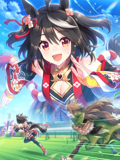

In [43]:
from core.utils.event_processor import Query, retrieve_best


ocr_title = "Ah, Friendship"

portrait_crop = "temp/Kitasan Black_SSR.png"

q = Query(
    ocr_title=ocr_title,
    # type_hint="support",            # support | trainee | scenario
    # name_hint="Kitasan Black",      # optional
    # rarity_hint="R",              # optional
    portrait_path=portrait_crop,
    # chain_step_hint=2,   # tell the retriever which chain step you’re seeing
)

candidates = retrieve_best(cat, q, top_k=5)
for i, r in enumerate(candidates, 1):
    print(f"{i:>2}. {r.rec.key:80s} | score={r.score:.3f}  "
          f"(text={r.text_sim:.3f} img={r.img_sim:.3f} bonus={r.hint_bonus:.3f})")

best = candidates[0]
print("\nBest match:", best.rec.key)
pick = prefs.pick_for(best.rec)
print("Resolved option (with prefs):", pick)
preview_option(best.rec, pick)
show_image(best.rec.image_path, title="Matched catalog image")


## Static check

In [4]:
# from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
from core.settings import Settings

img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl = StaticImageController(img)

assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))


Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


In [5]:
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

catalog = Catalog.load(CATALOG_JSON)
user_prefs = UserPrefs.load(USER_PREFS)

game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

event_flow = EventFlow(ctrl, ocr, yolo_engine, waiter, catalog, user_prefs)
decision = event_flow.process_event_screen(game_img, parsed_objects_screen)
decision

EventDecision(matched_key='support/Kitasan Black/SSR/Paying It Forward', matched_key_step='support/Kitasan Black/SSR/Paying It Forward#s2', pick_option=1, clicked_box=(195.1823272705078, 447.48779296875, 623.1138305664062, 507.81689453125), debug={'chain_step_hint': 2, 'num_choices': 2, 'has_event_card': True, 'ocr_title': 'Support Card Event', 'ocr_description': 'Paying It Forward', 'top_match': {'key': 'support/Kitasan Black/SSR/Paying It Forward', 'key_step': 'support/Kitasan Black/SSR/Paying It Forward#s2', 'score': 1.0753125, 'text_sim': 1.0, 'img_sim': 0.78125, 'bonus': 0.16}, 'pick_resolved': 1, 'expected_n_options': 2})

## Agent

In [10]:
# core/agent.py
from __future__ import annotations

from time import sleep

from core.actions.claw import ClawGame
from core.actions.events import EventFlow
from core.actions.lobby import LobbyFlow
from core.actions.race import RaceFlow
from core.actions.skills import SkillsFlow
from core.actions.training_policy import (
    TrainAction,
    click_training_tile,
    check_training
)
from core.controllers.base import IController
from core.perception.analyzers.screen import classify_screen
from core.perception.extractors.state import extract_goal_text, extract_skill_points, find_best
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector
from core.settings import Settings
from core.utils.logger import logger_uma
from typing import Optional
from core.utils.text import fuzzy_contains
from core.utils.waiter import PollConfig, Waiter
from core.actions.race import ConsecutiveRaceRefused
from core.utils.abort import abort_requested
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

class Player:
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        yolo_engine: IDetector,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig = PollConfig(
            imgsz=Settings.YOLO_IMGSZ,
            conf=Settings.YOLO_CONF,
            iou=Settings.YOLO_IOU,
            poll_interval_s=0.5,
            timeout_s=4.0,
            tag="player",
        ),
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh = 3,
        select_style = None
    ) -> None:
        self.ctrl = ctrl
        self.ocr = ocr
        self.yolo_engine = yolo_engine
        self.is_running = False
        self.imgsz = Settings.YOLO_IMGSZ
        self.conf = Settings.YOLO_CONF
        self.iou = Settings.YOLO_IOU
        self.prioritize_g1 = bool(prioritize_g1)
        self._skip_training_race_once = False
        self.plan_races = dict(plan_races or {})

        # Vision params used by Waiter & flows
        self.skill_list = skill_list or []

        self.auto_rest_minimum = auto_rest_minimum

        # Shared Waiter for the whole agent
        self.waiter = Waiter(self.ctrl, self.ocr, self.yolo_engine, waiter_config)

        # Flows
        self.race = RaceFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)
        self.lobby = LobbyFlow(
            self.ctrl,
            self.ocr,
            self.yolo_engine,
            self.waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            interval_stats_refresh=interval_stats_refresh,
            plan_races=self.plan_races,
        )
        self.skills_flow = SkillsFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)

        catalog = Catalog.load(CATALOG_JSON)
        user_prefs = UserPrefs.load(USER_PREFS)
        self.event_flow = EventFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter, catalog, user_prefs)

        self.claw_game = ClawGame(self.ctrl, self.yolo_engine)
        self.claw_turn = 0

        self._iterations_turn = 0
        self._minimum_skill_pts = int(minimum_skill_pts)
        self.patience = 0
        self.select_style = select_style
    
    def _desired_race_today(self) -> str | None:
        """
        If we have a planned race for today's date (Y{year}-{MM}-{half}),
        return its name; otherwise None.
        """
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        key = f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"
        plan = getattr(self.lobby, "plan_races", None) or self.plan_races
        race = plan.get(key)
        if race:
            logger_uma.info(f"[agent] Planned race for {key}: {race}")
        return race

    def _today_date_key(self) -> Optional[str]:
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        return f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"

    # --------------------------
    # Main loop
    # --------------------------
    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        while self.is_running:
            # Hard-stop hook (F2)
            if abort_requested():
                logger_uma.info("[agent] Abort requested; exiting main loop immediately.")
                break
            sleep(delay)
            img, _, dets = self.yolo_engine.recognize(
                imgsz=self.imgsz, conf=self.conf, iou=self.iou, tag="screen"
            )

            screen, _ = classify_screen(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            if unknown_screen:
                threshold = 0.65
                if self.patience > 20 == 0:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=("button_green", "race_after_next", "button_white"),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning("Stopping the algorithm just for safeness, nothing happened in 20 iterations")
                        self.is_running = False
                        break
                continue

            if screen == "Event":
                self.claw_turn = 0
                decision = self.event_flow.process_event_screen(img, dets)
                logger_uma.debug(f"[Event] {decision}")
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                inspiration = find_best(dets, "event_inspiration", conf_min=0.4)
                if inspiration:
                    self.ctrl.click_xyxy_center(inspiration["xyxy"], clicks=1)
                continue

            if screen == "Raceday":
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}")

                # If enough points, go to skills and auto-buy (unchanged logic)
                if self.lobby.state.skill_pts >= self._minimum_skill_pts and len(self.skill_list) > 0:
                    self.lobby._go_skills()

                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                career_date_raw = (self.lobby.state.career_date_raw or "")

                race_predebut = 'predebut' in career_date_raw.lower().replace("-", "")
                logger_uma.debug(f"Race day, is predebut= {race_predebut}")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = extract_goal_text(self.ocr, img, dets) or ""

                    
                    race_predebut = fuzzy_contains(self.lobby.state.goal.lower(), "junior make debut", threshold=0.8)
                    logger_uma.debug(f"Unknown date but  select_style= {self.select_style}. checking goal: {self.lobby.state.goal.lower()}. race debut?:{race_predebut}")

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    # Run RaceFlow; it will ensure navigation into Raceday if needed
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=self.select_style,
                        from_raceday=True,
                        reason="Pre-debut (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    # Mark raced on current date-key to avoid double-race if date OCR doesn't tick
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
                else:
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=None,
                        from_raceday=True,
                        reason="Normal (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue


            if screen == "Lobby" or is_lobby_summer:
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=True, is_g1_goal=True, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (G1 target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            try:
                                ok = self.race.run(
                                    prioritize_g1=self.prioritize_g1,
                                    is_g1_goal=False,
                                    desired_race_name=desired_race_name,
                                    date_key=self._today_date_key(),
                                    reason=f"Planned race: {desired_race_name}",
                                )
                            except ConsecutiveRaceRefused:
                                logger_uma.info("[lobby] Consecutive race refused on planned race → back & skip once.")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                continue
                            if not ok:
                                logger_uma.error(f"[race] Couldn't race {desired_race_name}")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.mark_raced_today(self._today_date_key())

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=self.prioritize_g1, is_g1_goal=False, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → back & skip once.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (fans target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self._handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                if self.lobby._go_skills():
                    sleep(1.0)
                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    self.is_running = False  # end of career
                    logger_uma.info("Detected end of career")
                    
                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue
            
            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}")
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def _handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        if not self.is_running:
            return
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        if not self.is_running:
            return
        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx)
            if not ok:
                logger_uma.error("[training] Failed to click training tile idx=%s", tidx)
            return

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby (RaceFlow will navigate into Raceday)
                try:
                    if self.race.run(prioritize_g1=self.prioritize_g1, reason="Training policy → race"):
                        return
                except ConsecutiveRaceRefused:
                    logger_uma.info("[training] Consecutive race refused → back to training and skip once.")
                    self.lobby._go_back()
                    self.lobby._skip_race_once = True
                    self._skip_training_race_once = True
                    if self.lobby._go_training_screen_from_lobby(None, None):
                        decision2 = check_training(self, skip_race=True)
                        if decision2 and decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                            click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning("[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found).")
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                        click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    else:
                        logger_uma.info("[training] Second decision after failed race: %s", decision2.action.value)
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")

    # ------------- Hard-stop helper -------------
    def emergency_stop(self) -> None:
        """Cooperative, best-effort immediate stop hook."""
        self.is_running = False
        try:
            # Release any possible held inputs if controller exposes such methods
            if hasattr(self.ctrl, "release_all"):
                self.ctrl.release_all()  # type: ignore[attr-defined]
        except Exception:
            pass

## RUN

In [11]:
from server.utils import load_config, ensure_config_exists
cfg = load_config()

Settings.apply_config(cfg or {})
Settings.FAST_MODE = True

# 4) Extract preset-specific runtime opts (skill_list / plan_races / select_style)
preset_opts = Settings.extract_runtime_preset(cfg or {})

# 5) Instantiate Player with runtime knobs from Settings + presets
player = Player(
    ctrl=ctrl,
    ocr=ocr,
    yolo_engine=yolo_engine,
    interval_stats_refresh=1,
    minimum_skill_pts=Settings.MINIMUM_SKILL_PTS,
    prioritize_g1=False,
    auto_rest_minimum=Settings.AUTO_REST_MINIMUM,
    plan_races=preset_opts["plan_races"],
    skill_list=preset_opts["skill_list"],
    select_style=preset_opts["select_style"],  # "end"|"late"|"pace"|"front"|None
)

player.run()

22:01:40 DEBUG   lobby.py:567: [date] prev: None. Cand: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None). accepted: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None)
22:01:40 INFO    lobby.py:568: [date] initial: None -> Y1
22:01:40 INFO    lobby.py:133: Date: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None) | raw: Junior Year Pre-Debut
22:01:40 INFO    lobby.py:773: [lobby] No critical actions → go Train
22:01:41 DEBUG   state.py:292: Stat 88 < 90 without trailing letter; treating as unrecognized (raw='88')
22:01:41 DEBUG   lobby.py:350: [stats] imputed ['WIT'] with avg=124
22:01:41 INFO    lobby.py:361: [stats] update: SPD:-1->128, STA:-1->142, PWR:-1->125, GUTS:-1->102
22:01:41 INFO    429480152.py:340: [lobby] goal='None' | energy=98 | skill_pts=0 | turn=11 | summer=False | mood=('NORMAL', 3) | stats={'SPD': 128, 'STA': 142, 'PWR': 125, 'GUTS': 102, 'WIT': 124} |
22:01:45 INFO    training_policy.py:719: View 

KeyboardInterrupt: 

# END